In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os, shutil
import random
import matplotlib.pyplot as plt
import string
import cv2
from google.colab.patches import cv2_imshow
import scipy

In [0]:
def getModelWeightsAsDict():
  
  keras.backend.clear_session()
  tf.reset_default_graph()
  model = keras.applications.VGG19(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
  
  with keras.backend.get_session() as sess:
    weights_dict = {}
    for i in range(len(model.layers)):
      weights_dict['layer_' + str(i)] = []
      for j in range(len(model.layers[i].weights)):
        weights_dict['layer_' + str(i)].append(sess.run(model.layers[i].weights[j]))
  tf.reset_default_graph()
  return weights_dict

In [0]:
def get_nst_model(weights_dict):
  
  layers = {}

  image_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
  layers['input'] = tf.Variable(initial_value=tf.initializers.random_normal().__call__((1,)+image_shape),expected_shape=(1,)+image_shape,
                       name='nst_output',dtype=tf.float32)

  layers['conv1_1'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['input'],weights_dict['layer_1'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_1'][1]))
  layers['conv1_2'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv1_1'],weights_dict['layer_2'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_2'][1]))
  layers['pool1'] = tf.nn.avg_pool(layers['conv1_2'],ksize=(1,2,2,1),strides=(1,2,2,1),padding='VALID')

  layers['conv2_1'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['pool1'],weights_dict['layer_4'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_4'][1]))
  layers['conv2_2'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv2_1'],weights_dict['layer_5'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_5'][1]))
  layers['pool2'] = tf.nn.avg_pool(layers['conv2_2'],ksize=(1,2,2,1),strides=(1,2,2,1),padding='VALID')


  layers['conv3_1'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['pool2'],weights_dict['layer_7'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_7'][1]))
  layers['conv3_2'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv3_1'],weights_dict['layer_8'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_8'][1]))
  layers['conv3_3'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv3_2'],weights_dict['layer_9'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_9'][1]))
  layers['conv3_4'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv3_3'],weights_dict['layer_10'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_10'][1]))

  layers['pool3'] = tf.nn.avg_pool(layers['conv3_4'],ksize=(1,2,2,1),strides=(1,2,2,1),padding='VALID')


  layers['conv4_1'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['pool3'],weights_dict['layer_12'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_12'][1]))
  layers['conv4_2'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv4_1'],weights_dict['layer_13'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_13'][1]))
  layers['conv4_3'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv4_2'],weights_dict['layer_14'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_14'][1]))
  layers['conv4_4'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv4_3'],weights_dict['layer_15'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_15'][1]))

  layers['pool4'] = tf.nn.avg_pool(layers['conv4_4'],ksize=(1,2,2,1),strides=(1,2,2,1),padding='VALID')



  layers['conv5_1'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['pool4'],weights_dict['layer_17'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_17'][1]))
  layers['conv5_2'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv5_1'],weights_dict['layer_18'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_18'][1]))
  layers['conv5_3'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv5_2'],weights_dict['layer_19'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_19'][1]))
  layers['conv5_4'] = tf.nn.relu(tf.nn.bias_add(tf.nn.convolution(layers['conv5_3'],weights_dict['layer_20'][0],padding='SAME',strides=(1,1)),
                                            weights_dict['layer_20'][1]))

  layers['pool5'] = tf.nn.avg_pool(layers['conv5_4'],ksize=(1,2,2,1),strides=(1,2,2,1),padding='VALID')
  
  return layers





In [0]:
CONTENT_LAYERS = [
#     ('conv1_2', 0.2),
#     ('conv2_2', 0.2),
#     ('conv3_2', 0.2),
    ('conv4_2', 1.0),
#     ('conv5_2', 1.0),
]
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)
]



def getContentLoss(layers,content_target,content_layer_name):
  
  m,H,W,C = content_target.shape
  return tf.reduce_sum(tf.pow(content_target-layers[content_layer_name],2))/(4.0*C*H*W)


def getStyleLoss(layers,style_target,style_layer_name):
  m,H,W,C = style_target.shape
  
  style_target = tf.transpose(tf.reshape(style_target,[H*W,C]))
  gram_target = tf.matmul(style_target,tf.transpose(style_target))
  
  style_tensor = tf.transpose(tf.reshape(layers[style_layer_name],[H*W,C]))
  gram_tensor = tf.matmul(style_tensor,tf.transpose(style_tensor))  
  
  return tf.reduce_sum(tf.pow(gram_tensor-gram_target,2))/(4.0*C*C*H*H*W*W)

def getTotalLoss(J_content,J_style,alpha,beta):
  return J_content*alpha + J_style*beta

In [0]:
MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    
  
def load_image(filename):
  
  image = cv2.imread(filename)
  image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
  cv2_imshow(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.reshape((1,)+image.shape)
  
  image = image - MEANS
  return image


def save_image(image,filename):
  #image = (image + 1) * 127.5
  image = image + MEANS
  image = np.clip(image[0], 0, 255).astype('uint8')
  scipy.misc.imsave(filename, image)
  return image
  

def generate_noise_image():
    # Generate a random noise_image
    noise_image = np.random.uniform(0, 255, (1, IMAGE_SIZE, IMAGE_SIZE, 3)).astype('uint8')
    noise_image = noise_image - MEANS
    return noise_image


In [0]:
def run_style_transfer(content_image_filename,
                      style_image_filename,
                      initialImage=None,
                      alpha=10,beta=1e-1,
                      epochs=1200,
                      learning_rate=5.0,
                      prefix=None):
  
  if prefix is None:
    print('Output file prefix not defined...')
    return
  
  content_image = load_image(content_image_filename)
  style_image = load_image(style_image_filename)
  
  

  weights_dict = getModelWeightsAsDict()
  tf.reset_default_graph()
  layers = get_nst_model(weights_dict)

  print('Model graph generated...\n')
  
  # Calculate tensor for content loss
  J_content = 0.0
  with tf.Session() as sess:
    for content_layer_name, weight in CONTENT_LAYERS:
      content_layer = layers[content_layer_name]
      content_target = sess.run(content_layer,feed_dict={layers['input']:content_image})
      J_content = J_content + weight * getContentLoss(layers,content_target, content_layer_name)
  print('Content loss defined...\n')
  
  
  # Calculate tensor for style loss
  J_style = 0.0
  with tf.Session() as sess:
    for style_layer_name, weight in STYLE_LAYERS:
        style_layer = layers[style_layer_name]
        style_target = sess.run(style_layer,feed_dict={layers['input']:style_image})
        J_style = J_style + weight * getStyleLoss(layers,style_target,style_layer_name)
  print('Style loss defined...\n')
  
  J_total = getTotalLoss(J_content,J_style,alpha=alpha,beta=beta)

  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(J_total)

  print('Losses defined...\n')
  
  print('Trainable variables:\n',tf.trainable_variables())
  
  with tf.Session() as sess:
    
    # Initialize image
    sess.run(tf.global_variables_initializer())
    if initialImage is not None:
      sess.run(layers['input'].assign(initialImage))
    else:
      sess.run(layers['input'].assign(generate_noise_image()))
      
    for epoch in range(epochs):

      epoch_loss, epoch_content_loss, epoch_style_loss, _ = sess.run([J_total,J_content,J_style,optimizer])

      if (epoch+1) % 250 == 0:
        generated_image = sess.run(layers['input'])
        generated_image = save_image(generated_image,prefix + '_' + str(epoch+1) + '.jpg')
        print('Loss after epoch %d: \nT: %f, \nC: %f, \nS: %f'%(epoch,epoch_loss,epoch_content_loss,epoch_style_loss))
        generated_image = cv2.cvtColor(generated_image, cv2.COLOR_RGB2BGR)
        cv2_imshow(generated_image)







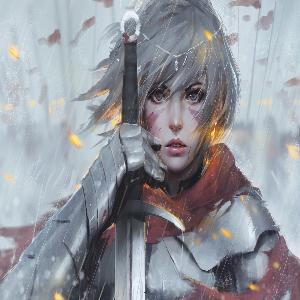

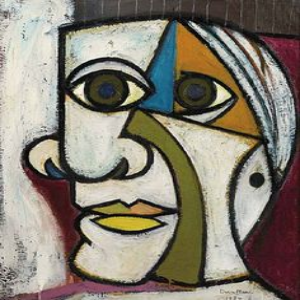

Model graph generated...

Content loss defined...

Style loss defined...

Losses defined...

Trainable variables:
 [<tf.Variable 'nst_output:0' shape=(1, 300, 300, 3) dtype=float32_ref>]
Loss after epoch 249: 
T: 175062.468750, 
C: 8535.663086, 
S: 4702752.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


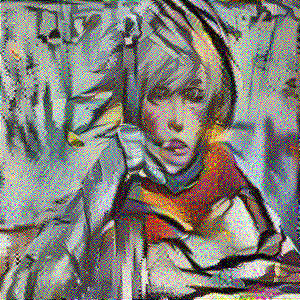

Loss after epoch 499: 
T: 151523.281250, 
C: 7435.482422, 
S: 3999104.000000


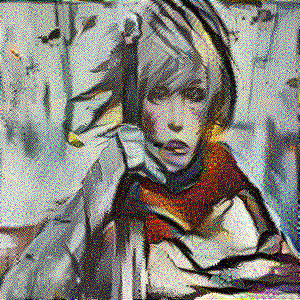

Loss after epoch 749: 
T: 147530.593750, 
C: 7316.923828, 
S: 3777673.250000


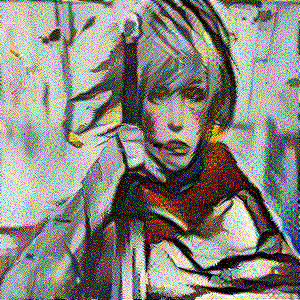

Loss after epoch 999: 
T: 167936.187500, 
C: 8005.367676, 
S: 4785567.500000


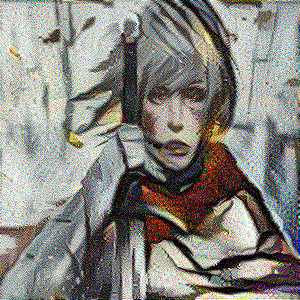

Loss after epoch 1249: 
T: 146412.750000, 
C: 7116.885742, 
S: 3965946.500000


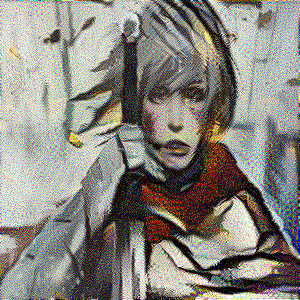

In [15]:
# Example Usage
IMAGE_SIZE = 300
content_image_filename = './knight.jpg'
style_image_filename = './/cubist.jpg'
run_style_transfer(content_image_filename=content_image_filename,
                  style_image_filename=style_image_filename,
                  epochs=1250,
                  alpha=15,
                  beta=1e-2,
                  learning_rate=10.0,
                  prefix='knight-cubist')

    
    